Import necessary packages: Numpy, Pandas, matplotlib

In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#import random
import statistics

Mount your google drive (if you have a google account) or upload files (go on the file icon on the left -> right click). Copy path of zip.train and zip.test and load them as numpy arrays using the following code (insert the path as string).

In [3]:
#path_to_train = '/content/drive/My Drive/ML_Class_2020/KNN/zip.train'
#path_to_test = '/content/drive/My Drive/ML_Class_2020/KNN/zip.test'
path_to_train = '/Users/Eva/Downloads/zip.train'
path_to_test = '/Users/Eva/Downloads/zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. Note the only difference is
# that we don't load as many ones as we load zeros.

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1][:30]
X_train = np.vstack((X_train_0, X_train_1))

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1][:30]
y_train = np.hstack((y_train_0, y_train_1))

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1][:12]
X_test = np.vstack((X_test_0, X_test_1))

y_test_0 = y_test[y_test == 0]
y_test_1 = y_test[y_test == 1][:12]
y_test = np.hstack((y_test_0, y_test_1))
print(y_test.shape)

(371,)


In [4]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')


(90,)


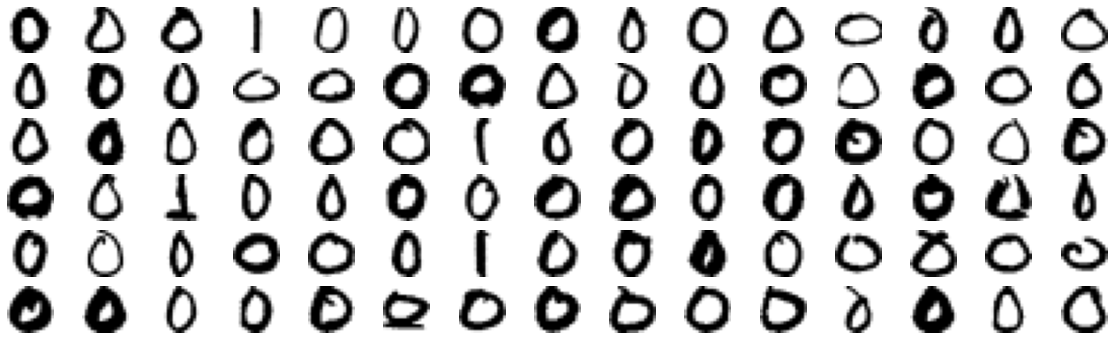

In [5]:
show_numbers(X_test)

Choose one of the classifiers you implemented and use it on the following task: Take a look at the provided notebook. It loads the ZIP-Code’s zeros and ones, but now there are manymore zeros than there are ones. We are going to believe that these digits represent genetic data. Actually, we are virologists trying to develop a test to determine which of the data belongs to infected patients (the ones) and which do not (the zeros). Train/apply your model on the data and do the tasks of the exercise.

# Exercise 1. Cross-Validation
Use a 5-fold Cross-Validation to evaluate your model and optimize hyperparameters (e.g.
the threshold in Logistic Regression or k in K-NNs). Print the mean and variance of your
validation. What do both values tell you about your model?

## 1.1) kNN Implementation

In [6]:
class KNearestNeighbors:
    '''
    Think about defining more functions that will help you building this algorithm.
    Optimally, one that takes in k and a test image as a parameter.
    '''
    def squared_euclidean_distance(self, x_1, x_2):
      '''
      np.sum(x, axis = 1) will be summing all elements over the pixel dimension (axis = 1)
      '''
      return np.sum((x_1-x_2)**2, axis = 1)

    def __init__(self, k): 
        self.k = k
    
    def get_neighbourhood(self, X_train, X_test_set):
        """
        Get all pairwise distances.
        """
        return self.squared_euclidean_distance(X_train, X_test_set)
    
    def get_k_smallest_distances(self, distances):
        """
        Return the k closest data points in input distance list.
        """
        enumerated = list(enumerate(distances))
        index_sorted = sorted(enumerated, key=lambda x:x[1])
        return [index_sorted[i][0] for i in range(self.k)]
    
    def get_majority_voted_y_label(self, Y_train, k_smallest_pos):
        """
        Determine label by getting majority vote of k nearest labels.
        """
        selected_labels = np.array([int(Y_train[i]) for i in k_smallest_pos])
        return np.argmax(np.bincount(selected_labels))
                
    def classify_single(self, X_train, Y_train, X_test_set):
        """
        Label one query data point using kNN.
        """
        distances = self.get_neighbourhood(X_train, X_test_set)
        k_smallest_pos = self.get_k_smallest_distances(distances)
        return self.get_majority_voted_y_label(Y_train, k_smallest_pos)
        
    def classify_loop(self, X_train, Y_train, X_test):
        """
        Classify all instances in test set.
        """
        return [self.classify_single(X_train, Y_train, X_test_set) for X_test_set in X_test] 
    
    def calculate_accuracy(self, true_y, pred_y, classes):
        """
        Calculate accuracy for a classified set.
        """
        class_sum = 0
        for class_num in classes:
            val_sum = 0
            for true_val, pred_val in zip(true_y, pred_y): 
                if class_num == true_val:
                    if true_val == pred_val:
                        val_sum += 1
            class_sum += val_sum
        return class_sum / len(true_y)

## 1.2) 5-fold Cross-Validation

In [7]:
def cross_validation(X_train, y_train, Ks, nr_folds = 5):
    """
    Split training data (X_train, y_train) into nr_folds many folds of 80% training and 20% validation set.
    Train and evaluate len(Ks) many kNN classifiers on each fold using different neighborhood sizes k. 
    Return accuracies.
    """
    all_accuracies = []
    #shoudn't the random shuffle only happen only once, then loop through the shuffled folds
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    fold_indices_list = np.array_split(indices, nr_folds)
    for fold_counter, val_indices in enumerate(fold_indices_list):
#         same as above, only shuffle once
#         choices = list(range(len(X_train)))
#         random.shuffle(choices) 
#         val_indeces = [x for x in choices if x not in train_indeces]
        X_val = X_train[val_indices]
        y_val = y_train[val_indices]
        X_training = np.delete(X_train, val_indices, 0)
        y_training = np.delete(y_train, val_indices, 0)
        accuracy_list = []
        for k in Ks:
            kNN = KNearestNeighbors(k)
            y_pred = kNN.classify_loop(X_training, y_training, X_val)
            accuracy_list += [kNN.calculate_accuracy(y_val, y_pred, list(range(2)))]
        all_accuracies += [accuracy_list]
    return(np.array(all_accuracies))

## 1.3) Show the mean and variance of validation accuracies for different k's

In [8]:
Ks = range(2,21)
nr_folds = 5
acc = cross_validation(X_train, y_train, Ks, nr_folds)

In [9]:
acc.shape

(5, 19)

See below the accuracies for each 5-fold evaluated value k:

In [10]:
acc_T = acc.T
acc_T

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [11]:
# mean of accuracy per k:
for row in acc_T:
    print(np.mean(row))
# np.mean(acc_T, axis=1)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


For measuring the error of our cross validated kNN, we decided to use a very basic and undifferentiated metric, which is 1-accuracy, i.e. the amount of false classifications.
The plot below shows the density of measured error across the cross validation process. Since the error is zero across all ks and folds, there is no variance as well. It appears, our model has zero bias and variance, i.e. the model neither under- nor overfitted the data.

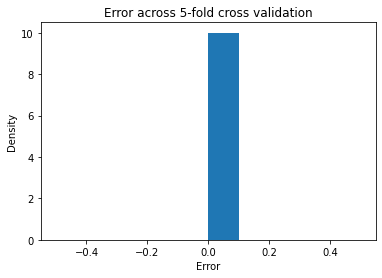

In [41]:
error = [1-v for elem in acc for v in elem]
plt.figure()
plt.title('Error across 5-fold cross validation')
plt.hist(error, label='error',density=True)
plt.xlabel('Error')
plt.ylabel('Density')
plt.show()

In [42]:
# variance of error per k:
for row in acc_T:
    print(statistics.variance([1-v for v in row]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [44]:
# Mean error and overall variance
print('Mean error: {}'.format(np.mean(error)))
print('Overall variance: {}'.format(statistics.variance(error)))

Mean error: 0.0
Overall variance: 0.0


# Exercise 2. Confusion Matrix
Calculate the confusion matrix of your model.

## a) How many true positive/true negative/false positive/false negative observations are there?

In [45]:
def calculate_confusion_matrix(y_pred, y_true, class_label_list):
    """
    Returns a confusion matrix (ndarray) for all class labels given in class_label_list.
    The order of class_label_list is preserved.
    The first returned dimension(rows) are the predicted labels, the second one(columns) are the true labels.
    """
    confusion_matrix = []
    for class_label_pred in class_label_list:
        class_row = []
        for class_label_true in class_label_list:
            bool_pred = (y_pred == class_label_pred)
            bool_true = (y_true == class_label_true)
            occurrences = np.sum(np.logical_and(bool_pred, bool_true))
            class_row.append(occurrences)
        confusion_matrix.append(class_row)
    return np.array(confusion_matrix)

def display_confusion_matrix(y_pred, y_true, class_label_list):
    """Returns a labeled pandas DataFrame made from a confusion matrix (ndarray)"""
    confusion_matrix = calculate_confusion_matrix(y_pred, y_true, class_label_list)
    pred_labels = ["pred: " + str(x) for x in class_label_list]
    true_labels = ["true: " + str(x) for x in class_label_list]
    return pd.DataFrame(confusion_matrix, index=pred_labels, columns=true_labels)

Now, we will train a kNN classifier on the complete training data with k=5 chosen empirically. We consider 1 to be the positive class and 0 to be the negative class.

In [47]:
# just selected k = 5 empirically
kNN = KNearestNeighbors(5)
y_pred_confusion = np.array(kNN.classify_loop(X_train, y_train, X_test))

In [48]:
# set 1 as the first/positive class and 0 as the second/negative class
class_label_list = np.unique(y_test)[::-1]
class_label_list

array([1., 0.])

In [49]:
display_confusion_matrix(y_pred_confusion, y_test, class_label_list)

,true: 1.0,true: 0.0
pred: 1.0,12,1
pred: 0.0,0,358


## b) Calculate the precision, recall, F1-score of your model. Compare it to a baseline (model) that always predicts negative (zero) for every sample. What is the difference between accuracy and F1-score?


In [50]:
def calculate_evaluation_metrics(y_pred, y_true, class_label_list):
    """
    Returns prediction evaluation metrics in a dictionary.
    All single class metrics are reported as an array, 
    where position i represents the metric value for the class at class_label_list[i]
    """
    evaluation_metrics = {}
    confusion_matrix = calculate_confusion_matrix(y_pred, y_true, class_label_list)
    evaluation_metrics["accuracy"] = np.sum(confusion_matrix.diagonal()) / np.sum(confusion_matrix)
    
    precisions = []
    for i in range(len(class_label_list)):
        precisions.append(confusion_matrix[i][i] / np.sum(confusion_matrix[i]))
    evaluation_metrics["precision"] = np.array(precisions)
    
    recalls = []
    confusion_matrix_t = confusion_matrix.T
    for i in range(len(class_label_list)):
        recalls.append(confusion_matrix_t[i][i] / np.sum(confusion_matrix_t[i]))
    evaluation_metrics["recall"] = np.array(recalls)
    
    evaluation_metrics["f1-score"] = 2 / ((1 / evaluation_metrics["precision"]) + (1 / evaluation_metrics["recall"]))
    
    return evaluation_metrics

def print_metrics(metrics):
    """
    Print out evaluation metrics in a nive visual format.
    """
    for key in metrics:
        if type(metrics[key]) is np.ndarray:
            for class_label, entry in zip(class_label_list, metrics[key]):
                print('{} (positive class = {}):\t{:f}'.format(key,class_label,entry))
        else:
            print(key,'\t', metrics[key])

In [51]:
# Print the metrics for the kNN model from task 2.a
class_label_list = np.unique(y_test)[::-1]
print('Confusion matrix:\n')
print(display_confusion_matrix(y_pred_confusion, y_test, class_label_list))
print()
metrics_kNN = calculate_evaluation_metrics(y_pred_confusion, y_test, class_label_list)
print_metrics(metrics_kNN)

Confusion matrix:

           true: 1.0  true: 0.0
pred: 1.0         12          1
pred: 0.0          0        358

accuracy 	 0.9973045822102425
precision (positive class = 1.0):	0.923077
precision (positive class = 0.0):	1.000000
recall (positive class = 1.0):	1.000000
recall (positive class = 0.0):	0.997214
f1-score (positive class = 1.0):	0.960000
f1-score (positive class = 0.0):	0.998605


In [54]:
# print the metrics for a model that just sets everything to 0
y_pred_all_0 = np.zeros(len(y_test))
class_label_list = np.unique(y_test)[::-1]
print('Confusion matrix:\n')
print(display_confusion_matrix(y_pred_all_0, y_test, class_label_list))
print()
metrics_all_0 = calculate_evaluation_metrics(y_pred_all_0, y_test, class_label_list)
print_metrics(metrics_all_0)

Confusion matrix:

           true: 1.0  true: 0.0
pred: 1.0          0          0
pred: 0.0         12        359

accuracy 	 0.967654986522911
precision (positive class = 1.0):	nan
precision (positive class = 0.0):	0.967655
recall (positive class = 1.0):	0.000000
recall (positive class = 0.0):	1.000000
f1-score (positive class = 1.0):	nan
f1-score (positive class = 0.0):	0.983562


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


### Model Comparison
First of all:
- Obviously the precision for the baseline model with class 1 as the positive class can't be computed, since 0 / (0 + 0) is undefined (the same applies for the f1 score in this case). 
- The trained kNN performs better regarding all metrics, except for the recall of class 0, which obvoiusly always equals 1 when every prediction is 0.
<br>
We consider class 1 as our positive class here. Due to the above mentioned precision and f1 score issue, the models can only be directly compared with respect to accuracy and recall:
<br> The performance lead of the trained kNN with respect to accuracy and recall is only marginal since class 1 is underrepresented and setting everything to the overrepresented class (0) yielded almost the same accuracy for the baseline model.

### What is the difference between accuracy and F1-score?
Accuracy only considers the amount of correctly classified instances and is applied to measure true positives and true negatives.
The F1-score considers incorrectly classified items and pays more respect to false positives and false negatives. The F1 score also is able to balance out unbalanced class counts.

## c) If your test is positive, what is the probability for a patient to be actually positive. Would you recommend using the test you developed? Describe what the problem is if there is one.
The probability to be truly positive out of all predicted positives is the Precision, i.e. the amount ot correctly classified positives out of all instances that were labelled positive (here with positive class 1):

In [55]:
print('P(positive|tested positive) = {}%'.format(100*metrics_kNN["precision"][np.where(class_label_list==1)][0]))

P(positive|tested positive) = 92.3076923076923%


This test is pretty accurate at showing a true positive result, if the test predicts a positive result, even if the true class is underrepresented. Though a test should also assure with high probability that a negatively classified patient is really negative. Our kNN model showed a negative precision of 100%.
So this test could be recommended.